*sections marked with {M} must be ran for other cells to function*

---


# **{M} Google Drive mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **{M} imports**


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

!pip install mne --upgrade
import mne

from mne.filter import notch_filter as notch
from mne.time_frequency import tfr_morlet as morl
from mne.time_frequency import tfr_array_morlet as amorl

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

from mne.decoding import CSP
from sklearn.model_selection import train_test_split as Split

print('[imports successfully loaded]')

     |████████████████████████████████| 6.8MB 8.8MB/s 
[imports successfully loaded]



---


# **{M} Class Subject**

In [ ]:
class Subject:
    def __init__(self, name, data_dir=None):
        """
        :param name: patient name - 'D0**' is the general format
        :param data_dir: str - path to the directory containing the .set files
        """
        self.data_dir = data_dir
        self.name = name
        self.set_names = ['NoShow_match', 'NoShow_non_match', 'Show_match', 'Show_non_match']

        # labels are set such that a 'rewarding' situation is 1 and 'punishment' is 0 #
        self.labels = {self.set_names[0]: 0, self.set_names[1]: 1, self.set_names[2]: 0, self.set_names[3]: 1}
        self.sets = {}
        if self.data_dir: self.load_sets(self.data_dir)
        print(self)

    def __getitem__(self, item):
        """
        :param item: item number
        :return: mne.Epochs. set
        """
        name = self.set_names[item]
        print(f'Set Name: {name}, label: {self.labels[name]}')
        return self.sets[self.set_names[item]]

    def __repr__(self):
        return 'Subject\'s sets by number: (can refer to as Patient[number])\n' + str(self)

    def __str__(self):
        return ''.join([f'[{i}]: {name}\n' for i, name in enumerate(self.set_names)])

    def load_sets(self, data_dir):
        """
        loads the sets' data to mne.Epoch objects
        :param data_dir: str - path to the directory containing the .set files
        """
        path = f"{data_dir}{self.name}/eeglab/"
        files = [file for file in os.listdir(path) if 'Picked' not in file]
        for file in files:
            self.sets[file[5:-9]] = mne.read_epochs_eeglab(path + file)

    def _get_set_name(self, set_identifier=None):
        """
        allows for user live set name choice via name/number
        :return: the name of the wanted set
        """
        try:
            if isinstance(set_identifier, int):
                return self.set_names[set_identifier]
            elif isinstance(set_identifier, str):
                return set_identifier
            else:
                return self.set_names[int(input(f'what Epochs element do you want to edit?\n' + str(self)))]
        except Exception as e:
            raise e

    def reset_set(self, set_id=None):
        """
        Reloads the specified set
        :param set_id: set to reload via name/number
        """
        set_name = self._get_set_name(set_id)
        print(f'[Resetting set:{set_name}]')
        path = f'{self.data_dir}{self.name}\\eeglab\\'
        file = [file for file in os.listdir(path) if set_name in file]
        print(f'[set file: {path + file[0]}')
        self.sets[set_name] = mne.io.read_epochs_eeglab(path + file[0])

    def plot_set(self, set_id=None):
        """
        opens a mne.Epoch.plot() instance - allows for visual channel and/or epoch drop
        :param set_id: set to reload via name/number
        """
        set_name = self._get_set_name(set_id)
        print(f'[Editing set: {set_name}]')
        self.sets[set_name].plot(scalings={'eeg': 1e-3})

    def plot_set_butterfly(self, set_id=None):
        """
        opens a mne.Epoch.plot() instance - allows for visual channel and/or epoch drop. this opens in butterfly mode
        :param set_id: set to reload via name/number
        """
        set_name = self._get_set_name(set_id)
        print(f'[Editing set: {set_name}]')
        self.sets[set_name].plot(scalings={'eeg': 2e-4}, butterfly=True)

    def edit_set(self, set_id=None):
        """ alias for plot_set """
        self.plot_set(set_id)

    def filter_set(self, w_c=85.0, pf=False, set_id=None):
        """
        filters a set using a LPF with cutoff frequency w_c
        :param w_c: float. cuttof frequency for LPF (default=85Hz)
        :param pf: bool. plot flag - if True, PSD is plotted before and after filtering
        :param set_id: set to reload via name/number
        """
        set_name = self._get_set_name(set_id)  # get set number
        if pf: self.sets[set_name].plot_psd()
        self.sets[set_name].filter(l_freq=124.0, h_freq=w_c)
        if pf: self.sets[set_name].plot_psd()

    def filter_sets(self, w_c=85.0, pf=False):
        """
        filters the data using a LPF with cutoff frequency w_c
        :param w_c: float. cuttof frequency for LPF (default=85Hz)
        :param pf: bool. plot flag - if True, PSD is plotted before and after filtering
        """
        for name in self.set_names:
            self.filter_set(w_c, pf, name)

    def notch_set(self, freqs=None, pf=False, set_id=None):
        """
        filters the set using a notch filter
        :param freqs: frequencies to notch at, can be a float or list of floats(or integers)
        :param pf: bool. plot flag - if True, PSD is plotted before and after filtering
        :param set_id: set to reload via name/number
        """
        if freqs is None: freqs = [float(input('Notch frequency: '))]
        if not isinstance(freqs, np.ndarray): freqs = np.array(freqs)  # turn into numpy array

        set_name = self._get_set_name(set_id)  # get set number
        if pf: self.sets[set_name].plot_psd()
        
        self.sets[set_name]._data = notch(self.sets[set_name].get_data(), 250, freqs=freqs)
        if pf: self.sets[set_name].plot_psd()

    def notch_sets(self, freqs=None, pf=False):
        """
        filters the data using a notch filter
        :param freqs: frequencies to notch at, can be a float or list of floats(or integers)
        :param pf: bool. plot flag - if True, PSD is plotted before and after filtering
        """
        if freqs is None: freqs = [float(input('Notch frequency: '))]
        for name in self.set_names:
            self.notch_set(freqs, pf, name)

    # methods from here on will need revision @@@@
    def get_data_and_label(self):
        if not self.sets: raise PermissionError('Can\'t retrieve data before Epochs are loaded')

        X = self.sets[self.set_names[0]].get_data()
        y = self.labels[self.set_names[0]] * np.ones(X.shape[0])
        for rec_set in self.set_names[1:-1]:
            dt = self.sets[rec_set].get_data()
            X = np.concatenate((X, dt))
            y = np.concatenate((y, self.labels[rec_set] * np.ones(dt.shape[0])))
        return X, y

    def get_CSP(self, X=None, y=None):
        if X is None and y is None:
            X, y = self.get_data_and_label()
        X_train, X_test, y_train, y_test = self.split_data(X, y)
        return CSP().fit(X_train, y_train)
    # till here @@@@

    @staticmethod
    def split_data(X, y):
        return Split(X, y, test_size=0.20)

    def get_morlet(self, n, freqs, n_cycles=3):
        print('Calculating Morlet Wavelet Transform')
        return morl(self[n], freqs=freqs, n_cycles=n_cycles, average=False, return_itc=False)

print('[Class Subject successfully loaded]')


[Class Subject successfully loaded]



---

# **{M} Loading & Filtering**

In [ ]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/Project Domino/Macros/'
subj = Subject(name='D015', data_dir=DATA_DIR)

subj.filter_sets(w_c=80)
subj.notch_sets(freqs=[50])
  
print('[Data successfully loaded & filtered]')

Extracting parameters from /content/drive/My Drive/Colab Notebooks/Project Domino/Macros/D015/eeglab/D015_Show_match_chip.set...
Not setting metadata
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-3-27b4f0c9a25e>:40: RuntimeWarning: 51 channel names are too long, have been truncated to 15 characters:
['EEG_RHC3_EEG_RHC2', 'EEG_RHC4_EEG_RHC3', 'EEG_RHC5_EEG_RHC4', 'EEG_RHC6_EEG_RHC5', 'EEG_RHC7_EEG_RHC6', 'EEG_RHC8_EEG_RHC7', 'EEG_ROF3_EEG_ROF2', 'EEG_ROF4_EEG_ROF3', 'EEG_ROF5_EEG_ROF4', 'EEG_ROF6_EEG_ROF5', 'EEG_ROF7_EEG_ROF6', 'EEG_ROF8_EEG_ROF7', 'EEG_ROPR3_EEG_ROPR2', 'EEG_ROPR4_EEG_ROPR3', 'EEG_ROPR5_EEG_ROPR4', 'EEG_ROPR6_EEG_ROPR5', 'EEG_ROPR7_EEG_ROPR6', 'EEG_ROPR8_EEG_ROPR7', 'EEG_RMF2_EEG_RMF1', 'EEG_RMF3_EEG_RMF2', 'EEG_RMF4_EEG_RMF3', 'EEG_RMF5_EEG_RMF4', 'EEG_RMF6_EEG_RMF5', 'EEG_RMF7_EEG_RMF6', 'EEG_RMF8_EEG_RMF7', 'EEG_RASF2_EEG_RASF1', 'EEG_RASF3_EEG_RASF2', 'EEG_RASF4_EEG_RASF3', 'EEG_RASF5_EEG_RASF4', 'EEG_RASF6_EEG_RASF5', 'EEG_RASF7_EEG_RASF6', 'EEG_RASF8_EEG_RASF7', 'EEG_RAC2_EEG_RAC1', 'EEG_RAC3_EEG_RAC2', 'EEG_RAC4_EEG_RAC3', 'EEG_RAC5_EEG_RAC4', 'EEG_RAC6_EEG_RAC5', 'EEG_LHC2_EEG_LHC1', 'EEG_LHC3_EEG_LHC2', 'EEG_LHC4_EEG_LHC3', 'EEG_LHC5_EEG

Extracting parameters from /content/drive/My Drive/Colab Notebooks/Project Domino/Macros/D015/eeglab/D015_Show_non_match_chip.set...
Not setting metadata
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-3-27b4f0c9a25e>:40: RuntimeWarning: 51 channel names are too long, have been truncated to 15 characters:
['EEG_RHC3_EEG_RHC2', 'EEG_RHC4_EEG_RHC3', 'EEG_RHC5_EEG_RHC4', 'EEG_RHC6_EEG_RHC5', 'EEG_RHC7_EEG_RHC6', 'EEG_RHC8_EEG_RHC7', 'EEG_ROF3_EEG_ROF2', 'EEG_ROF4_EEG_ROF3', 'EEG_ROF5_EEG_ROF4', 'EEG_ROF6_EEG_ROF5', 'EEG_ROF7_EEG_ROF6', 'EEG_ROF8_EEG_ROF7', 'EEG_ROPR3_EEG_ROPR2', 'EEG_ROPR4_EEG_ROPR3', 'EEG_ROPR5_EEG_ROPR4', 'EEG_ROPR6_EEG_ROPR5', 'EEG_ROPR7_EEG_ROPR6', 'EEG_ROPR8_EEG_ROPR7', 'EEG_RMF2_EEG_RMF1', 'EEG_RMF3_EEG_RMF2', 'EEG_RMF4_EEG_RMF3', 'EEG_RMF5_EEG_RMF4', 'EEG_RMF6_EEG_RMF5', 'EEG_RMF7_EEG_RMF6', 'EEG_RMF8_EEG_RMF7', 'EEG_RASF2_EEG_RASF1', 'EEG_RASF3_EEG_RASF2', 'EEG_RASF4_EEG_RASF3', 'EEG_RASF5_EEG_RASF4', 'EEG_RASF6_EEG_RASF5', 'EEG_RASF7_EEG_RASF6', 'EEG_RASF8_EEG_RASF7', 'EEG_RAC2_EEG_RAC1', 'EEG_RAC3_EEG_RAC2', 'EEG_RAC4_EEG_RAC3', 'EEG_RAC5_EEG_RAC4', 'EEG_RAC6_EEG_RAC5', 'EEG_LHC2_EEG_LHC1', 'EEG_LHC3_EEG_LHC2', 'EEG_LHC4_EEG_LHC3', 'EEG_LHC5_EEG

Extracting parameters from /content/drive/My Drive/Colab Notebooks/Project Domino/Macros/D015/eeglab/D015_NoShow_match_chip.set...
Not setting metadata
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-3-27b4f0c9a25e>:40: RuntimeWarning: 51 channel names are too long, have been truncated to 15 characters:
['EEG_RHC3_EEG_RHC2', 'EEG_RHC4_EEG_RHC3', 'EEG_RHC5_EEG_RHC4', 'EEG_RHC6_EEG_RHC5', 'EEG_RHC7_EEG_RHC6', 'EEG_RHC8_EEG_RHC7', 'EEG_ROF3_EEG_ROF2', 'EEG_ROF4_EEG_ROF3', 'EEG_ROF5_EEG_ROF4', 'EEG_ROF6_EEG_ROF5', 'EEG_ROF7_EEG_ROF6', 'EEG_ROF8_EEG_ROF7', 'EEG_ROPR3_EEG_ROPR2', 'EEG_ROPR4_EEG_ROPR3', 'EEG_ROPR5_EEG_ROPR4', 'EEG_ROPR6_EEG_ROPR5', 'EEG_ROPR7_EEG_ROPR6', 'EEG_ROPR8_EEG_ROPR7', 'EEG_RMF2_EEG_RMF1', 'EEG_RMF3_EEG_RMF2', 'EEG_RMF4_EEG_RMF3', 'EEG_RMF5_EEG_RMF4', 'EEG_RMF6_EEG_RMF5', 'EEG_RMF7_EEG_RMF6', 'EEG_RMF8_EEG_RMF7', 'EEG_RASF2_EEG_RASF1', 'EEG_RASF3_EEG_RASF2', 'EEG_RASF4_EEG_RASF3', 'EEG_RASF5_EEG_RASF4', 'EEG_RASF6_EEG_RASF5', 'EEG_RASF7_EEG_RASF6', 'EEG_RASF8_EEG_RASF7', 'EEG_RAC2_EEG_RAC1', 'EEG_RAC3_EEG_RAC2', 'EEG_RAC4_EEG_RAC3', 'EEG_RAC5_EEG_RAC4', 'EEG_RAC6_EEG_RAC5', 'EEG_LHC2_EEG_LHC1', 'EEG_LHC3_EEG_LHC2', 'EEG_LHC4_EEG_LHC3', 'EEG_LHC5_EEG

Extracting parameters from /content/drive/My Drive/Colab Notebooks/Project Domino/Macros/D015/eeglab/D015_NoShow_non_match_chip.set...
Not setting metadata
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Ready.
[0]: NoShow_match
[1]: NoShow_non_match
[2]: Show_match
[3]: Show_non_match

Setting up band-stop filter from 80 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 sec)



<ipython-input-3-27b4f0c9a25e>:40: RuntimeWarning: 51 channel names are too long, have been truncated to 15 characters:
['EEG_RHC3_EEG_RHC2', 'EEG_RHC4_EEG_RHC3', 'EEG_RHC5_EEG_RHC4', 'EEG_RHC6_EEG_RHC5', 'EEG_RHC7_EEG_RHC6', 'EEG_RHC8_EEG_RHC7', 'EEG_ROF3_EEG_ROF2', 'EEG_ROF4_EEG_ROF3', 'EEG_ROF5_EEG_ROF4', 'EEG_ROF6_EEG_ROF5', 'EEG_ROF7_EEG_ROF6', 'EEG_ROF8_EEG_ROF7', 'EEG_ROPR3_EEG_ROPR2', 'EEG_ROPR4_EEG_ROPR3', 'EEG_ROPR5_EEG_ROPR4', 'EEG_ROPR6_EEG_ROPR5', 'EEG_ROPR7_EEG_ROPR6', 'EEG_ROPR8_EEG_ROPR7', 'EEG_RMF2_EEG_RMF1', 'EEG_RMF3_EEG_RMF2', 'EEG_RMF4_EEG_RMF3', 'EEG_RMF5_EEG_RMF4', 'EEG_RMF6_EEG_RMF5', 'EEG_RMF7_EEG_RMF6', 'EEG_RMF8_EEG_RMF7', 'EEG_RASF2_EEG_RASF1', 'EEG_RASF3_EEG_RASF2', 'EEG_RASF4_EEG_RASF3', 'EEG_RASF5_EEG_RASF4', 'EEG_RASF6_EEG_RASF5', 'EEG_RASF7_EEG_RASF6', 'EEG_RASF8_EEG_RASF7', 'EEG_RAC2_EEG_RAC1', 'EEG_RAC3_EEG_RAC2', 'EEG_RAC4_EEG_RAC3', 'EEG_RAC5_EEG_RAC4', 'EEG_RAC6_EEG_RAC5', 'EEG_LHC2_EEG_LHC1', 'EEG_LHC3_EEG_LHC2', 'EEG_LHC4_EEG_LHC3', 'EEG_LHC5_EEG

Setting up band-stop filter from 80 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 825 samples (3.300 sec)

Setting up band-stop filter from 80 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 80.00
- Lower transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 70.00 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff freq


---

# **Wavelet Transform - Morlet**



> Calculating




In [ ]:
set_number = 0
mrl = subj.get_morlet(set_number, freqs=np.arange(1, 101), n_cycles=3)
print('done!')


> Plotting

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

def plot_morlet(mrl, ep, r=5, c=5, norm=False, log=False):
    avg_spectrum = mrl.data.mean(axis=0)
    for n in range(int(len(mrl[0].ch_names) / (r * c)) + 1):
        fig, axs = plt.subplots(r, c)
        for i in range(r * c):
            try:
                ax = axs[int(i / c), i % c]
                plot_data = mrl.data[ep, r * c * n + i]
                if norm: plot_data = mrl.data[ep, r * c * n + i] / avg_spectrum

                im = ax.imshow(plot_data, aspect='auto', extent=[-2, 8, 100, 1])
                if log: ax.set_yscale('log')

                ax.set_title(mrl.ch_names[r * c * n + i], fontsize=8)
                fig.colorbar(im, ax=ax)
                # print(f'plotted ch number {r * c * n + i}')
            except Exception as e:
                ax.remove()
                pass
        plt.tight_layout()
        plt.show()
    

epoch_number, r, c = 2, 4, 4
plot_morlet(mrl, ep=epoch_number, r=r, c=c, norm=True, log=True)


Output hidden; open in https://colab.research.google.com to view.


---

# **PCA + MWT**



> Calculating PCA

In [ ]:
cur_set = subj[2]
X = cur_set.get_data()

# note that the mne UnsupSF is necesary for a correct application of PCA
n_comp = 20
pca = UnsupervisedSpatialFilter(PCA(n_comp), average=False)                     # type(pca)      = mne.decoding.transformer.UnsupervisedSpatialFilter
pca_data = pca.fit_transform(X)                                                 # type(pca_data) = numpy.ndarray
est = pca.get_params()['estimator']                                             # type(est)      = sklearn.decomposition._pca.PCA
pct_var = est.explained_variance_ratio_                                         


Set Name: Show_match, label: 0


> Calculating Morlet WT

In [ ]:
print('[Computing morlet transform]')
amrl = amorl(epoch_data=pca_data, sfreq=cur_set.info['sfreq'],
             freqs=np.arange(1,101), n_cycles=5.0, output='power')
print('[Done]')


[Computing morlet transform]
[Done]


> Plotting

total var explained: 93.301%


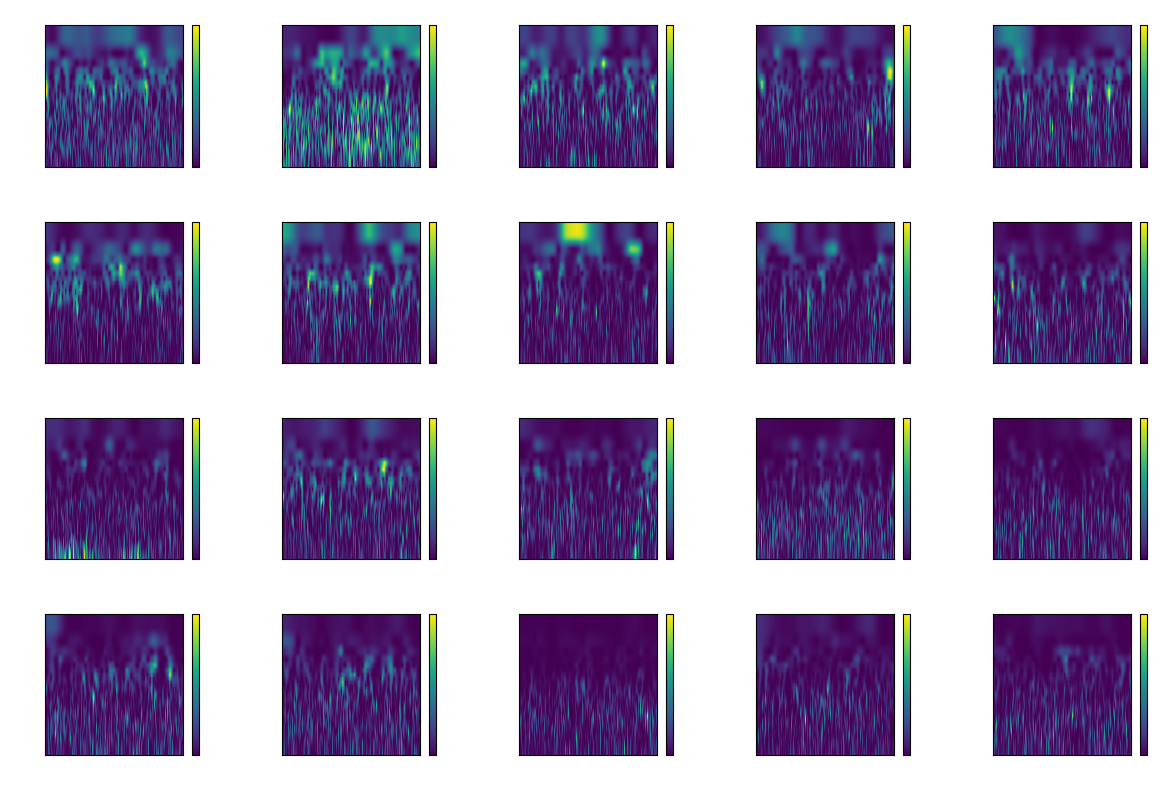

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

def plot_array_morlet(amrl, ep, p_var, r=5, c=5, norm=False, log=False):
    # amrl.shape = (18, 20, 100, 2500)
    for n_fig in range(int(amrl.shape[1]/(r*c))): # amrl.shape[1]/(r*c) = 20/20
        fig, axs = plt.subplots(r, c)
        for i_ax in range(r*c):
            try:
                ax = axs[int(i_ax / c), i_ax % c]
                plot_data = amrl[ep, (r*c* n_fig + i_ax)]
                if norm: plot_data = amrl[ep, r*c*n_fig + i_ax] / amrl[ep].mean(axis=0)
                
                im = ax.imshow(plot_data, aspect='auto', extent=[-2, 8, 100, 1])
                if log: ax.set_yscale('log')

                ax.set_title(f'PC {i_ax+1}, %var explained: {p_var[i_ax]:.3%}', fontsize=8)
                fig.colorbar(im, ax=ax)
                # print(f'plotted ch number {r*c * n_fig + i_ax}')
            except Exception as e:
                # print(f'Exception: {e}')
                ax.remove()
                pass
        plt.tight_layout()
        plt.show()

print(f'total var explained: {sum(pct_var):.3%}')
epoch_number, r, c = 4, 4, 5
plot_array_morlet(amrl, ep=epoch_number, p_var=pct_var, r=r, c=c, norm=True, log=True)


# for project purposes:

for now, we try to calssify per patient

feature extraction:

> divide to frequency bands

> divide time to ~200ms-250ms bins

> create electrode groups (consider normalization)

> (opt. - PCA for within group electrde)

> create per patient classifier(conv?) + feature engneering

> read about classifiers: SVM, Gaussian regression model, CNN(?), RNN(?)


# for in-depth analysis:



> for a patient - normalize signal per channel average (on all labels) 
[ z-norm(?) ]

we want to compare different channels in the same patient 
[ (and similar channels in different patients) ]

> get amplitude range per electrode / area [ (range, mean, std) ]